## Special Topics in Artificial Intelligence and Deep Learning (SCIFM0002)

### **Programming Project 2 - Dunking Biscuits in Tea**

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Reading in and Exploring Data

#### *"Big Data" Collection*

In [154]:
dunking_df = pd.read_csv('data/dunking-data.csv')
dunking_df.head()

,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


*Gamma* represents the surface tension of tea (N m<sup>-1</sup>), *phi* the contact angle between the biscuit and surface (rad), *eta* the tea dynamic viscosity (Pa s), *L* the distance up the biscuit that the tea was visible (m) and *t* the time after initial dunking that the measurement was made (s). *Biscuit* is a ternary variable representing biscuit type (digestive, hobnob or rich tea).

There are 3000 datapoints, and no missing values.

In [155]:
# exploring distribution of biscuit types
dunking_df['biscuit'].value_counts()

biscuit
Digestive    1000
Hobnob       1000
Rich Tea     1000
Name: count, dtype: int64

There are 1000 datapoints for each biscuit, meaning an even distribution. Therefore, no readjustment of class balances is required.

Text(0.5, 1.01, 'Dunking data distribution')

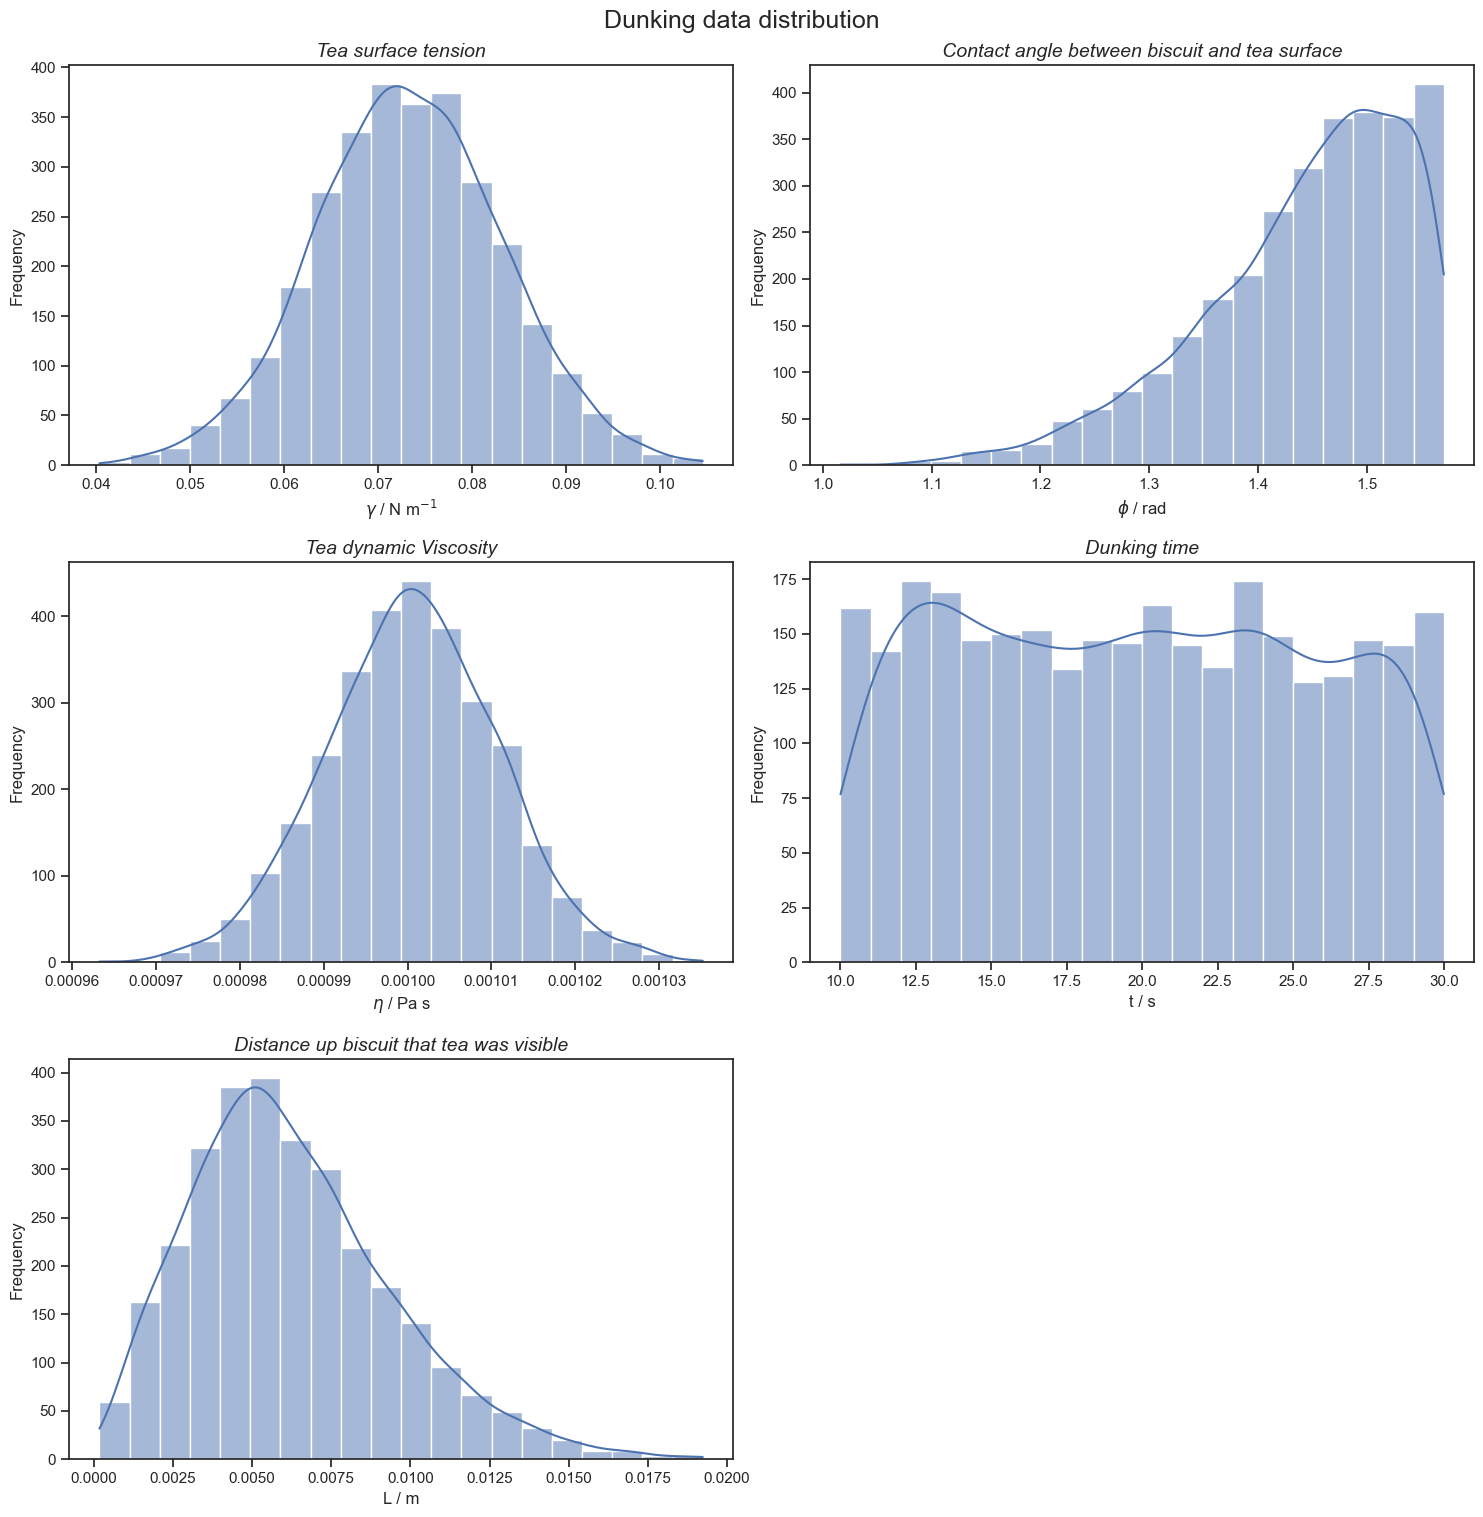

In [156]:
# exploring distribution of gamma (surface tension)
fig, ax = plt.subplots(3,2,figsize=(15,15))
sns.set_theme(style='ticks', font='Arial')

sns.histplot(data=dunking_df, x='gamma', bins=20, kde=True, ax=ax[0,0])
ax[0,0].set_title('Tea surface tension', fontsize=14, fontstyle='italic')
ax[0,0].set_xlabel(r'$\gamma$ / N m$^{-1}$', fontsize=12)
ax[0,0].set_ylabel('Frequency', fontsize=12)

sns.histplot(data=dunking_df, x='phi', bins=20, kde=True, ax=ax[0,1])
ax[0,1].set_title('Contact angle between biscuit and tea surface', fontsize=14, fontstyle='italic')
ax[0,1].set_xlabel(r'$\phi$ / rad', fontsize=12)
ax[0,1].set_ylabel('Frequency', fontsize=12)

sns.histplot(data=dunking_df, x='eta', bins=20, kde=True, ax=ax[1,0])
ax[1,0].set_title('Tea dynamic Viscosity', fontsize=14, fontstyle='italic')
ax[1,0].set_xlabel(r'$\eta$ / Pa s', fontsize=12)
ax[1,0].set_ylabel('Frequency', fontsize=12)

sns.histplot(data=dunking_df, x='t', bins=20, kde=True, ax=ax[1,1])
ax[1,1].set_title('Dunking time', fontsize=14, fontstyle='italic')
ax[1,1].set_xlabel('t / s', fontsize=12)
ax[1,1].set_ylabel('Frequency', fontsize=12)

sns.histplot(data=dunking_df, x='L', bins=20, kde=True, ax=ax[2,0])
ax[2,0].set_title('Distance up biscuit that tea was visible', fontsize=14, fontstyle='italic')
ax[2,0].set_xlabel('L / m', fontsize=12)
ax[2,0].set_ylabel('Frequency', fontsize=12)

# removing axes from subplot at bottom right
ax[2,1].axis('off')

fig.tight_layout()
fig.suptitle('Dunking data distribution', fontsize=18, y=1.01)

The above plots give information about the distribution of the 5 continuous variables in the big dataset. *t* ranges from 10 to 30 seconds, and shows a reasonably consistent distribution across this range. *Gamma* and *eta* show clear gaussian distributions. *L* also shows a gaussian distribution, but with a skew towards lower values (positive skew). *Phi* shows a significant skew towards larger values (negative skew).

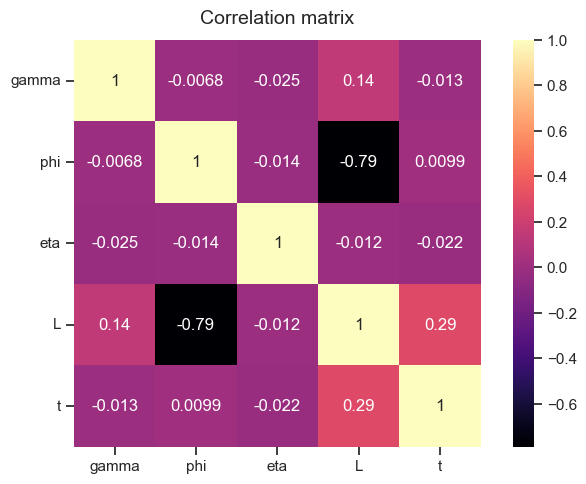

In [157]:
# exploring correlation between variables
dunking_numerical = dunking_df.drop(columns='biscuit')
corr = dunking_numerical.corr()

fig, ax = plt.subplots(figsize=(7,5))
sns.set_theme(style='ticks', font='Arial')

sns.heatmap(corr, annot=True, cmap='magma', square=True)
ax.set_title('Correlation matrix', fontsize=14, y=1.02)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

fig.tight_layout()

The correlation matrix shows there to be a significant negative correlation between *phi* and *L*. There is also a noteable correlation between *L* and *t*. There are however no clear relationships between the rest of the variables.

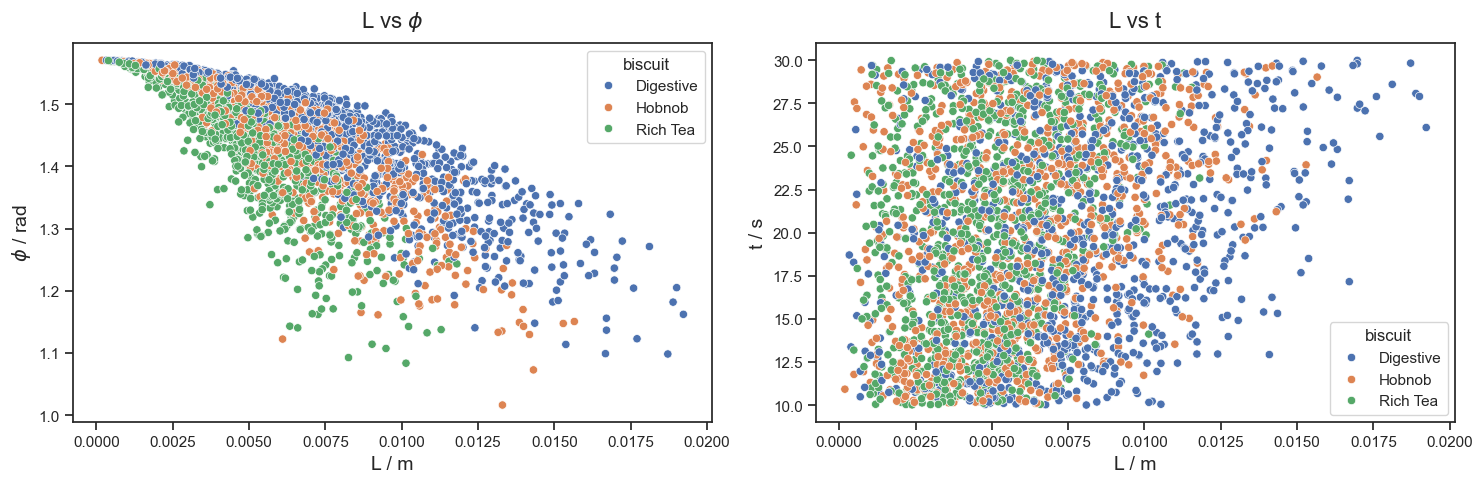

In [158]:
# plotting L vs phi and L vs t
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.set_theme(style='ticks', font='Arial')

sns.scatterplot(data=dunking_df, x='L', y='phi', hue='biscuit', ax=ax[0])
ax[0].set_title('L vs $\phi$', fontsize=16, y=1.02)
ax[0].set_xlabel('L / m', fontsize=14)
ax[0].set_ylabel(r'$\phi$ / rad', fontsize=14)

sns.scatterplot(data=dunking_df, x='L', y='t', hue='biscuit', ax=ax[1])
ax[1].set_title('L vs t', fontsize=16, y=1.02)
ax[1].set_xlabel('L / m', fontsize=14)
ax[1].set_ylabel('t / s', fontsize=14)

fig.tight_layout()

The *L* versus *phi* plot shows a negative relationship, as expected by the correlation coefficient. The three biscuit types are distinguishable, with digestives generally producing a larger *L* for a given *phi*.

The *L* versus *t* plot is more chaotic, with biscuit types showing a lot of overlap. At the highest *L* values, the weak positive correlation is clearest. This relationship would likely be more obvious when dealing with a larger range of *t*.

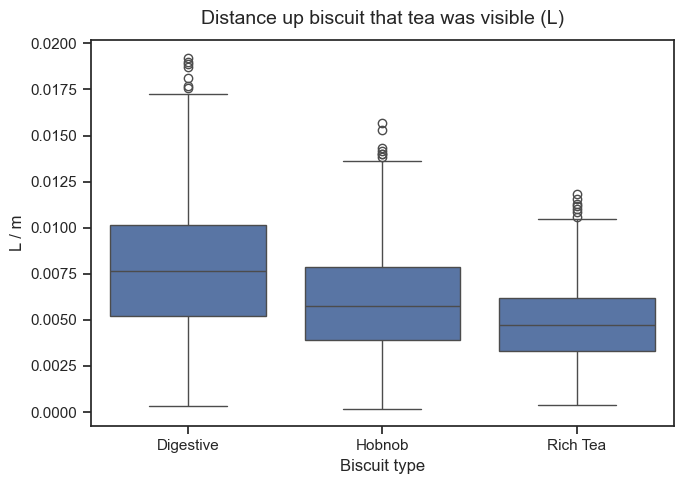

In [159]:
# box plots of L for each biscuit type
fig, ax = plt.subplots(figsize=(7,5))
sns.set_theme(style='ticks', font='Arial')

sns.boxplot(data=dunking_df, x='biscuit', y='L', ax=ax)
ax.set_title('Distance up biscuit that tea was visible (L)', fontsize=14, y=1.02)
ax.set_xlabel('Biscuit type', fontsize=12)
ax.set_ylabel('L / m', fontsize=12)

fig.tight_layout()

The box plot shows that the digestive has a wider range of *L* values and exhibits higher averages. The hobnob has the next highest average, followed by the rich tea.

#### *Time-Resolved Measurements*

In [160]:
tr1 = pd.read_csv('data/tr-1.csv')
tr2 = pd.read_csv('data/tr-2.csv')
tr3 = pd.read_csv('data/tr-3.csv')

tr1.head()

,t,L,dL
0,30.000000,0.008087,0.000392
1,32.727273,0.008253,0.000270
2,35.454545,0.008607,0.000501
3,38.181818,0.008920,0.000267
4,40.909091,0.009604,0.000274


In [161]:
# calculating correlation between L and t for each trial
trs = [tr1, tr2, tr3]
correlations = []

for tr in trs:
    correlation = tr['L'].corr(tr['t'])
    correlations.append(correlation)

print(f"Correlation between L and t for trial 1: {correlations[0]:.3f}")
print(f"Correlation between L and t for trial 2: {correlations[1]:.3f}")
print(f"Correlation between L and t for trial 3: {correlations[2]:.3f}")

Correlation between L and t for trial 1: 0.990
Correlation between L and t for trial 2: 0.991
Correlation between L and t for trial 3: 0.991


The above correlation coefficients show that there is a very strong positive correlation between *t* and *L*. This is expected, given the nature of the variables, and the greater range of *t* values than is observed in the big dataset.

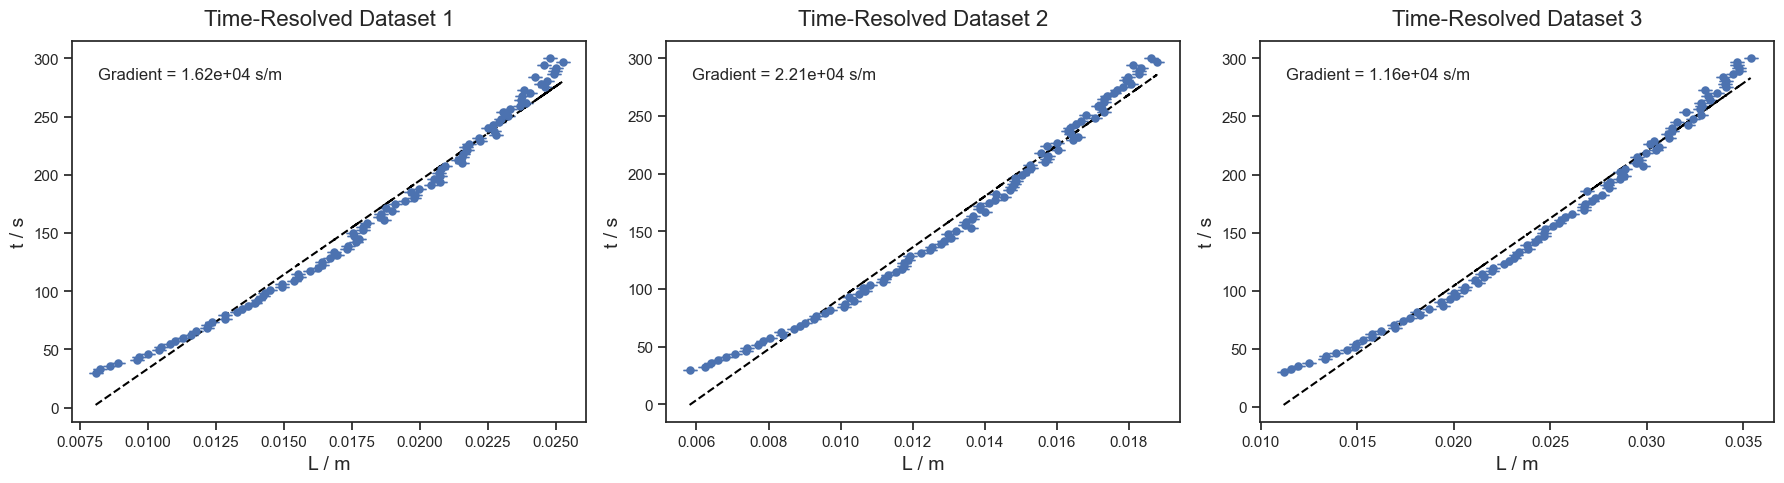

In [162]:
# plotting L vs t for each trial, adding error bars representing the dL (uncertainty in L)
fig, ax = plt.subplots(1,3, figsize=(18,5))
sns.set_theme(style='ticks', font='Arial')

for i, tr in enumerate([tr1, tr2, tr3]):
    sns.scatterplot(data=tr, x='L', y='t', ax=ax[i])
    ax[i].errorbar(tr['L'], tr['t'], yerr=tr['dL'], fmt='o', capsize=5, markersize=5)
    ax[i].set_title(f'Time-Resolved Dataset {i+1}', fontsize=16, y=1.02)
    ax[i].set_xlabel('L / m', fontsize=14)
    ax[i].set_ylabel('t / s', fontsize=14)

    # adding line of best fit and calculating gradient
    m, c = np.polyfit(tr['L'], tr['t'], 1)
    ax[i].plot(tr['L'], m*tr['L'] + c, color='black', linestyle='--')
    ax[i].text(0.05, 0.9, f'Gradient = {m:.3g} s/m', transform=ax[i].transAxes, fontsize=12)

fig.tight_layout()

All of the three time-resolved datasets show a similar, strong positive relationship between *t* and *L*. Given the weak positive correlation previously established, this was expected. TR3 has the smallest gradient value, indicating the smallest rate of change. It will therefore lead to the greatest *L* values; the hypothesis is therefore that this dataset corresponds to digestive data, as it has shown to lead to higher values of *L*. If that is the case, then TR1 would be hobnob and TR3, rich tea. This is explored later.

#### *Microscopy Measurements*

In [163]:
microscopy_df = pd.read_csv('data/microscopy-data.csv')

microscopy_df.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


Text(0.5, 1.01, 'Dunking data distribution - Micrscopy Dataset')

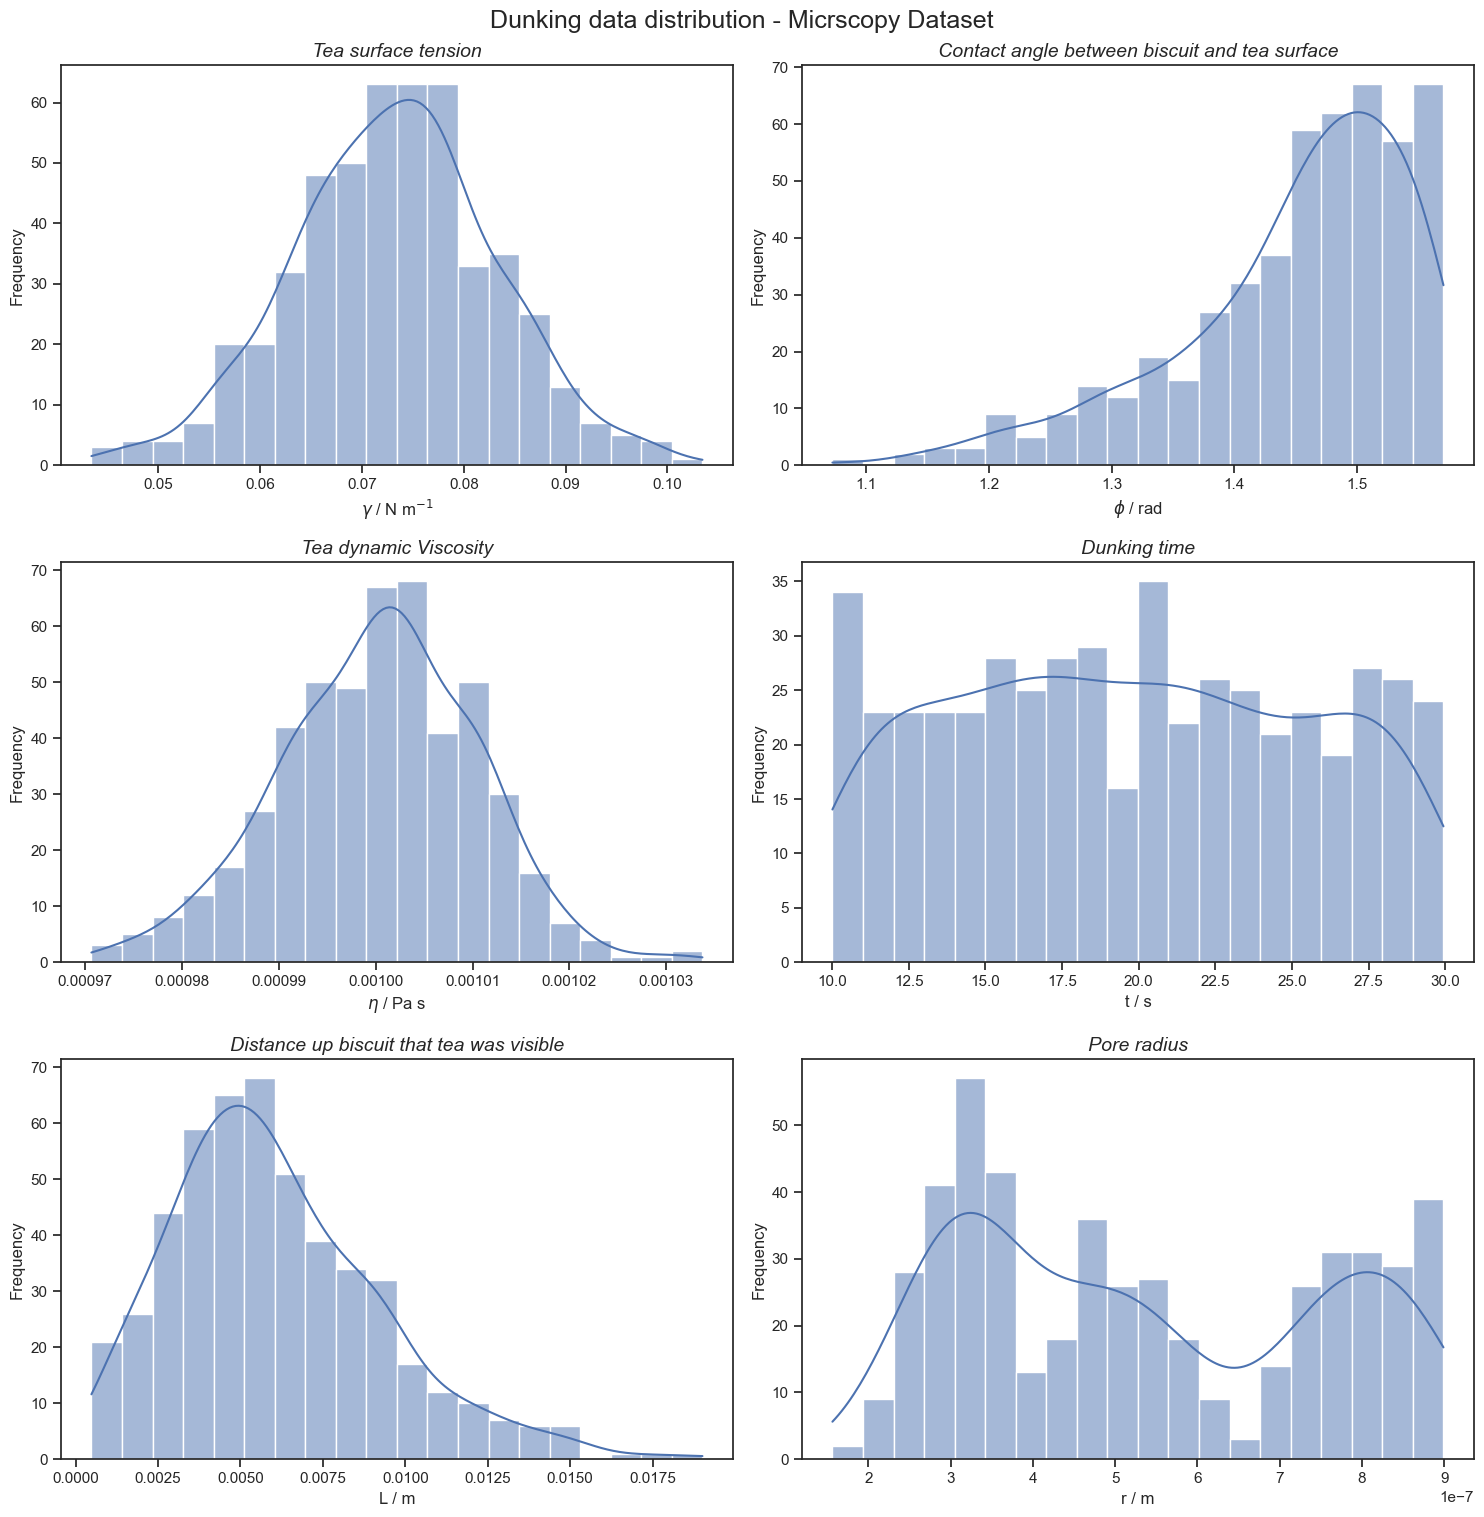

In [164]:
# exploring distribution of gamma (surface tension)
fig, ax = plt.subplots(3,2,figsize=(15,15))
sns.set_theme(style='ticks', font='Arial')

sns.histplot(data=microscopy_df, x='gamma', bins=20, kde=True, ax=ax[0,0])
ax[0,0].set_title('Tea surface tension', fontsize=14, fontstyle='italic')
ax[0,0].set_xlabel(r'$\gamma$ / N m$^{-1}$', fontsize=12)
ax[0,0].set_ylabel('Frequency', fontsize=12)

sns.histplot(data=microscopy_df, x='phi', bins=20, kde=True, ax=ax[0,1])
ax[0,1].set_title('Contact angle between biscuit and tea surface', fontsize=14, fontstyle='italic')
ax[0,1].set_xlabel(r'$\phi$ / rad', fontsize=12)
ax[0,1].set_ylabel('Frequency', fontsize=12)

sns.histplot(data=microscopy_df, x='eta', bins=20, kde=True, ax=ax[1,0])
ax[1,0].set_title('Tea dynamic Viscosity', fontsize=14, fontstyle='italic')
ax[1,0].set_xlabel(r'$\eta$ / Pa s', fontsize=12)
ax[1,0].set_ylabel('Frequency', fontsize=12)

sns.histplot(data=microscopy_df, x='t', bins=20, kde=True, ax=ax[1,1])
ax[1,1].set_title('Dunking time', fontsize=14, fontstyle='italic')
ax[1,1].set_xlabel('t / s', fontsize=12)
ax[1,1].set_ylabel('Frequency', fontsize=12)

sns.histplot(data=microscopy_df, x='L', bins=20, kde=True, ax=ax[2,0])
ax[2,0].set_title('Distance up biscuit that tea was visible', fontsize=14, fontstyle='italic')
ax[2,0].set_xlabel('L / m', fontsize=12)
ax[2,0].set_ylabel('Frequency', fontsize=12)

sns.histplot(data=microscopy_df, x='r', bins=20, kde=True, ax=ax[2,1])
ax[2,1].set_title('Pore radius', fontsize=14, fontstyle='italic')
ax[2,1].set_xlabel('r / m', fontsize=12)
ax[2,1].set_ylabel('Frequency', fontsize=12)

fig.tight_layout()
fig.suptitle('Dunking data distribution - Micrscopy Dataset', fontsize=18, y=1.01)

The variables within the microscopy dataset see the same distributions as the big dataset; this is because it is a subset. At first glance, the pore radius distribution appears random, however, upon further inspection there appears to be three distinct peaks (just above 3e<sup>-7</sup> m, just below 5e<sup>-7</sup> m and at 8e<sup>-7</sup> m). These likely correspond to the three biscuit types.

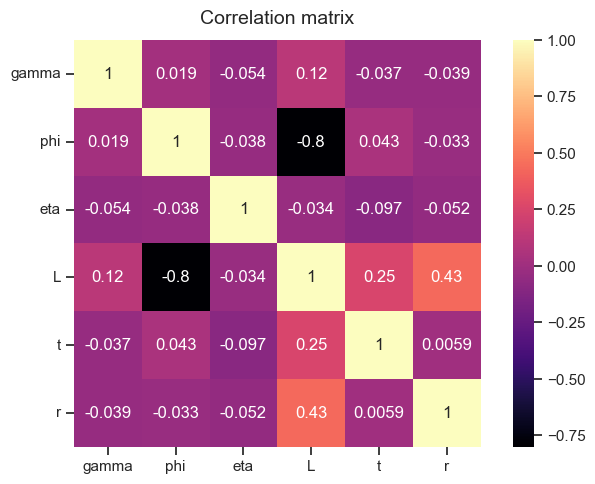

In [165]:
# exploring correlation between variables
corr = microscopy_df.corr()

fig, ax = plt.subplots(figsize=(7,5))
sns.set_theme(style='ticks', font='Arial')

sns.heatmap(corr, annot=True, cmap='magma', square=True)
ax.set_title('Correlation matrix', fontsize=14, y=1.02)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

fig.tight_layout()

The correlation matrix shows a positive correlation between *r* and *L*. The plot below the distribution; there appear to be three distinct groups of *r* values. The group with a mean aorund 8e<sup>-7</sup> m has a wider range of *L* values and so the initial hypothesis is that this corresponds to the digestive. This is explored later.

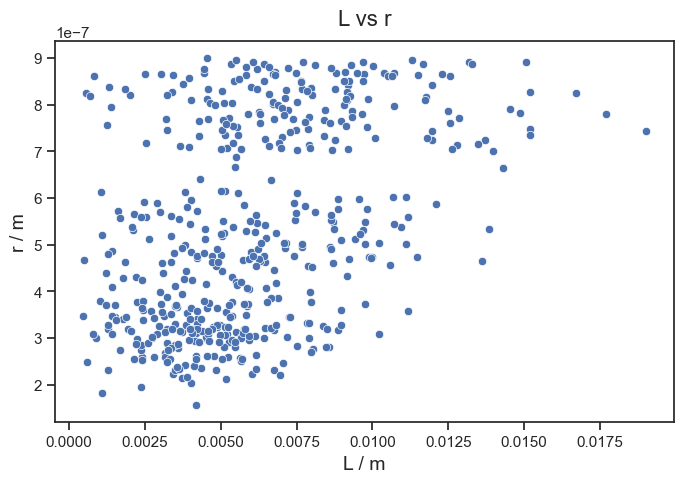

In [166]:
# plotting L vs r
fig, ax = plt.subplots(figsize=(7,5))
sns.set_theme(style='ticks', font='Arial')

sns.scatterplot(data=microscopy_df, x='L', y='r')
ax.set_title('L vs r', fontsize=16, y=1.02)
ax.set_xlabel('L / m', fontsize=14)
ax.set_ylabel('r / m', fontsize=14)

fig.tight_layout()

### *Using a Machine Learning Algorithm to Identify Biscuit Type*

#### Exploring & Optimising Classification Model Types

In [167]:
# setting up data for machine learning models

# identifying features and target variable (biscuit type)
X = dunking_df.drop('biscuit', axis=1)
y = dunking_df['biscuit']

# splitting into training and testing data - 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# splitting testing data further into testing and validation data - 18% testing, 12% validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, random_state=42)


# checking categories are balanced (within 5% of each other)
digestive_num = y_train.value_counts()['Digestive']
rich_tea_num = y_train.value_counts()['Rich Tea']
hobnob_num = y_train.value_counts()['Hobnob']

assert abs(digestive_num - rich_tea_num) < 0.05*digestive_num
assert abs(digestive_num - hobnob_num) < 0.05*digestive_num
assert abs(rich_tea_num - hobnob_num) < 0.05*rich_tea_num

##### **Random Forest**

In [168]:
# training a RF classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)

rf.fit(X_train, y_train)

# fitting model to test data
y_pred = rf.predict(X_test)

In [169]:
# evaluating model using F1 score and cross-validation
overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score: {np.mean(cv_scores):.3f}')

Overall F1: 0.785
Average Cross-validation F1 score: 0.818


##### **Gradient-Boosted Tree**

In [170]:
# training a GBT classifier
gbt = GradientBoostingClassifier(n_estimators=200, random_state=42)

gbt.fit(X_train, y_train)

# fitting model to test data
y_pred = gbt.predict(X_test)

In [171]:
# evaluating model using F1 score and cross-validation
overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

cv_scores = cross_val_score(gbt, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score: {np.mean(cv_scores):.3f}')

Overall F1: 0.817
Average Cross-validation F1 score: 0.826


##### **Neural Network**

In [172]:
# training a NN MLP classifier
nn = MLPClassifier(random_state=42)

nn.fit(X_train, y_train)

# fitting model to test data
y_pred = nn.predict(X_test)

In [173]:
# evaluating model using F1 score and cross-validation
overall_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Overall F1: {overall_f1:.3f}')

cv_scores = cross_val_score(nn, X, y, cv=5, scoring='f1_weighted')
print(f'Average Cross-validation F1 score: {np.mean(cv_scores):.3f}')

Overall F1: 0.267
Average Cross-validation F1 score: 0.218


Initial testing shows that the neural network is not appropriate for these data, likely as it is a relatively small and straightforward dataset. The random forest and gradient-boosted tree both perform well, but the gradient-boosted tree achieves the best F1 and cross-validation scores at this point. Therefore, the gradient-boosted tree is the choice of algorithm going forward, and will be optimised further through exploration of hyperparameter combinations in a grid search. This is done using the validation set.

##### **Optimation of Gradient-Boosted Tree**

In [174]:
# defining hyperparamters to search through
param_grid = {'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['friedman_mse', 'squared_error'],
    'random_state': [42],
    'learning_rate': [0.01, 0.1, 0.001],}

# Initialize the grid search with 5-fold cross-validation
grid_search = GridSearchCV(gbt, param_grid, n_jobs=-1, cv=5, scoring='f1')

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# extracting best parameters and score
results = grid_search.best_estimator_

validation_f1 = results.score(X_val, y_val)

print(f'Validation F1 Score: {validation_f1:.3f}')
print(f'Best Parameters: {grid_search.best_params_}')

c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\Artificial Intelligence and Deep Learning\Project2\Code\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
2430 fits failed out of a total of 7290.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1634 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\Artificial Intelligence and Deep Learning\Project2\Code\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\Artificial Intelligence and Deep Learning\Project2\Code\venv\Lib\site-packages\sklearn\base.py", l

InvalidParameterError: The 'max_features' parameter of GradientBoostingClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

#### Investigating Feature Importance

#### Evaluating Individual Class Performance of Final Model

In [113]:
# evaluating classifier using F1 score - obtaining values for each biscuit type
f1 = f1_score(y_test, y_pred, average=None, labels=['Digestive', 'Hobnob', 'Rich Tea'])
print(f'F1: {[f"{score:.3f}" for score in f1]}')

# printing confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

F1: ['0.867', '0.707', '0.833']
Predicted  Digestive  Hobnob  Rich Tea
Actual                                
Digestive        221      32         2
Hobnob            34     176        39
Rich Tea           0      41       205


In [118]:
# calculating percentage drop in F1 score between biscuit types
f1_diff = abs(f1[0] - f1[1])
f1_drop = f1_diff/f1[0] * 100
print(f'Percentage drop in F1 score from Digestive to Hobnob: {f1_drop:.2f}%')

f1_diff = abs(f1[1] - f1[2])
f1_drop = f1_diff/f1[1] * 100
print(f'Percentage drop in F1 score from Rich Tea to Hobnob: {f1_drop:.2f}%')

Percentage drop in F1 score from Digestive to Hobnob: 18.44%
Percentage drop in F1 score from Rich Tea to Hobnob: 17.90%


These values show that the model is able to accurately categorise data into biscuit type over 80% of the time. However, there is a significant drop in performance when considering the Hobnob data.

In [91]:
# identifying what hobnobs are being most commonly misclassified as
hobnob_matrix = confusion_matrix.loc['Hobnob']
hobnob_matrix = hobnob_matrix.drop('Hobnob')
max_value = hobnob_matrix.max()
hobnob_matrix = (hobnob_matrix / hobnob_matrix.sum())*100

print(f'Hobnobs are most commonly misclassified as: {hobnob_matrix.idxmax()}. {hobnob_matrix.max():.1f}% (n={max_value}) of Hobnob false positives are this biscuit type.')

# exploring to see if this is reciprocated
rich_tea_matrix = confusion_matrix.loc['Rich Tea']
rich_tea_matrix = rich_tea_matrix.drop('Rich Tea')
max_value = rich_tea_matrix.max()
rich_tea_matrix = (rich_tea_matrix / rich_tea_matrix.sum())*100


print(f'Rich Teas are most commonly misclassified as: {rich_tea_matrix.idxmax()}. {rich_tea_matrix.max():.1f}% (n={max_value}) of Rich Tea false positives are this biscuit type.')

Hobnobs are most commonly misclassified as: Rich Tea. 53.4% (n=39) of Hobnob false positives are this biscuit type.
Rich Teas are most commonly misclassified as: Hobnob. 100.0% (n=41) of Rich Tea false positives are this biscuit type.


These results show that while the algorithm shows significant potential for classification of biscuit type because of its high F1 and cross-validation scores, it struggles most with distinguishing hobnobs and rich teas. This is likely because their distributions are most similar and digestive is distinguishable from both, as shown in the boxplot of *L* in the above exploratory data analysis.

This is worth considering.

## To Do

### *Exploring Pore Radius*

In [62]:
tr1.head()

,t,L,dL,gamma,eta,phi
0,30.000000,0.008087,0.000392,0.0678,0.000993,1.45
1,32.727273,0.008253,0.000270,0.0678,0.000993,1.45
2,35.454545,0.008607,0.000501,0.0678,0.000993,1.45
3,38.181818,0.008920,0.000267,0.0678,0.000993,1.45
4,40.909091,0.009604,0.000274,0.0678,0.000993,1.45


In [74]:
tr1['gamma'] = 6.78e-2
tr1['eta'] = 9.93e-4
tr1['phi'] = 1.45

# calculating r based on Washburn equation
tr1['r'] = (tr1['L']**2 * 2*tr1['eta'])/(tr1['gamma']*tr1['t']*np.cos(tr1['phi']))

average_r = tr1['r'].mean()
print(f'Average r for tr-1: {average_r} m')
# hobnob 

Average r for tr-1: 5.190557826133109e-07 m


In [75]:
tr2['gamma'] = 6.78e-2
tr2['eta'] = 9.93e-4
tr2['phi'] = 1.45

# calculating r based on Washburn equation
tr2['r'] = (tr2['L']**2 * 2*tr2['eta'])/(tr2['gamma']*tr2['t']*np.cos(tr2['phi']))

average_r = tr2['r'].mean()
print(f'Average r for tr-2: {average_r} m')
# rich tea

Average r for tr-2: 2.794291267288034e-07 m


In [76]:
tr3['gamma'] = 6.78e-2
tr3['eta'] = 9.93e-4
tr3['phi'] = 1.45

# calculating r based on Washburn equation
tr3['r'] = (tr3['L']**2 * 2*tr3['eta'])/(tr3['gamma']*tr3['t']*np.cos(tr3['phi']))

average_r = tr3['r'].mean()
print(f'Average r for tr-3: {average_r} m')
# digestive

Average r for tr-3: 1.0036063064285083e-06 m


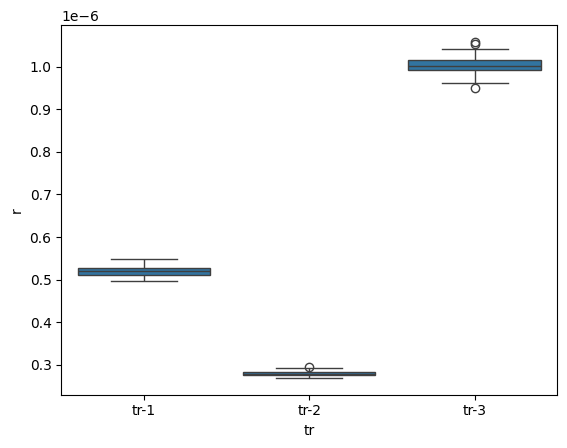

In [78]:
# boxplot showing r for each tr
tr1['tr'] = 'tr-1'
tr2['tr'] = 'tr-2'
tr3['tr'] = 'tr-3'

tr = pd.concat([tr1, tr2, tr3])

import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='tr', y='r', data=tr)
plt.show()

### *Calculating a Capillary Flow Rate Coefficient for the Different Biscuit Types*

### *Assessing the Washburn Equation*

### *Using a Machine Learning Regressor to Compete with the Washburn Equation*